<img src="https://raw.githubusercontent.com/retkowsky/images/master/logo%20azure%20cog%20svcs.jpg">

Documentation : https://azure.microsoft.com/en-us/services/cognitive-services/

In [133]:
import sys
sys.version

'3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) \n[GCC 7.3.0]'

In [134]:
import datetime
now = datetime.datetime.now()
print(now)


2020-07-07 14:20:39.876270


# Vision API

In [135]:
subscription_key = 'AREMPLACER'
assert subscription_key

Next, ensure that region in `vision_base_url` corresponds to the one where you generated the API key (`westus`, `westcentralus`, etc.). If you are using a free trial subscription key, you do not need to make any changes here.

In [136]:
vision_base_url = "https://westeurope.api.cognitive.microsoft.com/vision/v2.0/"

The image analysis URL looks like the following (see REST API docs [here](https://westcentralus.dev.cognitive.microsoft.com/docs/services/5adf991815e1060e6355ad44/operations/56f91f2e778daf14a499e1fa)):
<code>
https://[location].api.cognitive.microsoft.com/vision/v2.0/<b>analyze</b>[?visualFeatures][&details][&language]
</code>

In [137]:
vision_analyze_url = vision_base_url + "analyze"

To begin analyzing an image, set `image_url` to the URL of any image that you want to analyze.

In [138]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/1/12/Broadway_and_Times_Square_by_night.jpg/450px-Broadway_and_Times_Square_by_night.jpg"

The following block uses the `requests` library in Python to call out to the Computer Vision `analyze` API and return the results as a JSON object. The API key is passed in via the `headers` dictionary and the types of features to recognize via the `params` dictionary. To see the full list of options that can be used, refer to the [REST API](https://westcentralus.dev.cognitive.microsoft.com/docs/services/5adf991815e1060e6355ad44/operations/56f91f2e778daf14a499e1fa) documentation for image analysis.

In [139]:
import requests
headers  = {'Ocp-Apim-Subscription-Key': subscription_key }
params   = {'visualFeatures': 'Categories,Description,Color'}
data     = {'url': image_url}
response = requests.post(vision_analyze_url, headers=headers, params=params, json=data)
response.raise_for_status()
analysis = response.json()

The `analysis` object contains various fields that describe the image. The most relevant caption for the image can be obtained from the `descriptions` property.

In [140]:
image_caption = analysis["description"]["captions"][0]["text"].capitalize()
print(image_caption)

A group of people on a city street at night


The following lines of code display the image and overlay it with the inferred caption.

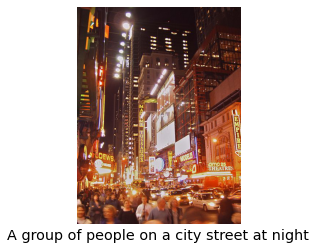

In [141]:
%matplotlib inline
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
image = Image.open(BytesIO(requests.get(image_url).content))
plt.imshow(image)
plt.axis("off")
_ = plt.title(image_caption, size="x-large", y=-0.1)

## Use a domain-specific model <a name="DomainSpecificModel"> </a>

A [domain-specific model](https://westcentralus.dev.cognitive.microsoft.com/docs/services/5adf991815e1060e6355ad44/operations/56f91f2e778daf14a499e1fd)  is a model trained to identify a specific set of objects in an image.  The two domain-specific models that are currently available are _celebrities_ and _landmarks_. 

To view the list of domain-specific models supported, you can make the following request against the service.

In [142]:
model_url = vision_base_url + "models"
headers   = {'Ocp-Apim-Subscription-Key': subscription_key}
models    = requests.get(model_url, headers=headers).json()
[model["name"] for model in models["models"]]

['celebrities', 'landmarks']

### Landmark identification
To begin using the domain-specific model for landmarks, set `image_url` to point to an image to be analyzed.

In [143]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/f/f6/Bunker_Hill_Monument_2005.jpg"

The service endpoint to analyze images for landmarks can be constructed as follows:

In [144]:
landmark_analyze_url = vision_base_url + "models/landmarks/analyze"
print(landmark_analyze_url)

https://westeurope.api.cognitive.microsoft.com/vision/v2.0/models/landmarks/analyze


The image in `image_url` can now be analyzed for any landmarks. The identified landmark is stored in `landmark_name`.

In [145]:
headers  = {'Ocp-Apim-Subscription-Key': subscription_key}
params   = {'model': 'landmarks'}
data     = {'url': image_url}
response = requests.post(landmark_analyze_url, headers=headers, params=params, json=data)
response.raise_for_status()

analysis      = response.json()
assert analysis["result"]["landmarks"] is not []

landmark_name = analysis["result"]["landmarks"][0]["name"].capitalize()

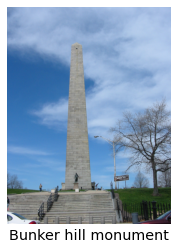

In [146]:
image = Image.open(BytesIO(requests.get(image_url).content))
plt.imshow(image)
plt.axis("off")
_ = plt.title(landmark_name, size="x-large", y=-0.1)

### Celebrity identification
Along the same lines, the domain-specific model for identifying celebrities can be invoked as shown next. First set `image_url` to point to the image of a celebrity.

In [147]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/d/d9/Bill_gates_portrait.jpg"

The service endpoint for detecting celebrity images can be constructed as follows:

In [148]:
celebrity_analyze_url = vision_base_url + "models/celebrities/analyze"
print(celebrity_analyze_url)

https://westeurope.api.cognitive.microsoft.com/vision/v2.0/models/celebrities/analyze


Next, the image in `image_url` can be analyzed for celebrities

In [149]:
headers  = {'Ocp-Apim-Subscription-Key': subscription_key}
params   = {'model': 'celebrities'}
data     = {'url': image_url}
response = requests.post(celebrity_analyze_url, headers=headers, params=params, json=data)
response.raise_for_status()

analysis = response.json()

In [150]:
print(analysis)

{'result': {'celebrities': [{'faceRectangle': {'top': 126, 'left': 157, 'width': 185, 'height': 185}, 'name': 'Bill Gates', 'confidence': 0.9999994039535522}]}, 'requestId': 'a54ef9ca-d567-4a13-b4d3-0db570f89d23', 'metadata': {'width': 550, 'height': 521, 'format': 'Jpeg'}}


The following lines of code extract the name and bounding box for one of the celebrities found:

In [151]:
assert analysis["result"]["celebrities"] is not []
celebrity_info = analysis["result"]["celebrities"][0]
celebrity_name = celebrity_info["name"]
celebrity_face = celebrity_info["faceRectangle"]

Next, this information can be overlaid on top of the original image using the following lines of code:

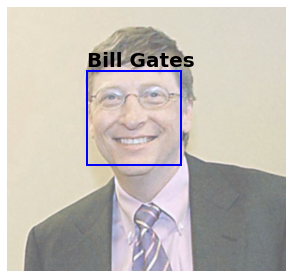

In [152]:
from matplotlib.patches import Rectangle
plt.figure(figsize=(5,5))

image  = Image.open(BytesIO(requests.get(image_url).content))
ax     = plt.imshow(image, alpha=0.6)
origin = (celebrity_face["left"], celebrity_face["top"])
p      = Rectangle(origin, celebrity_face["width"], celebrity_face["height"], 
                   fill=False, linewidth=2, color='b')
ax.axes.add_patch(p)
plt.text(origin[0], origin[1], celebrity_name, fontsize=20, weight="bold", va="bottom")
_ = plt.axis("off")

## Get a thumbnail with Computer Vision API
<a name="GetThumbnail"> </a>

Use the [Get Thumbnail method](https://westcentralus.dev.cognitive.microsoft.com/docs/services/5adf991815e1060e6355ad44/operations/56f91f2e778daf14a499e1fb) to crop an image based on its region of interest (ROI) to the height and width you desire. The aspect ratio you set for the thumbnail can be different from the aspect ratio of the input image.

To generate the thumbnail for an image, first set `image_url` to point to its location. 

In [153]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/9/94/Bloodhound_Puppy.jpg"

The service endpoint to generate the thumbnail can be constructed as follows:

In [154]:
thumbnail_url = vision_base_url + "generateThumbnail"
print(thumbnail_url)

https://westeurope.api.cognitive.microsoft.com/vision/v2.0/generateThumbnail


Next, a 50-by-50 pixel thumbnail for the image can be generated by calling this service endpoint.

In [155]:
headers  = {'Ocp-Apim-Subscription-Key': subscription_key}
params   = {'width': '50', 'height': '50','smartCropping': 'true'}
data     = {'url': image_url}
response = requests.post(thumbnail_url, headers=headers, params=params, json=data)
response.raise_for_status()

You can verify that the thumbnail is indeed 50-by-50 pixels using the Python Image Library.

Thumbnail is 50-by-50


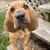

In [156]:
thumbnail = Image.open(BytesIO(response.content))
print("Thumbnail is {0}-by-{1}".format(*thumbnail.size))
thumbnail

## Optical character recognition (OCR) with Computer Vision API <a name="OCR"> </a>

Use the [Optical Character Recognition (OCR) method](https://westcentralus.dev.cognitive.microsoft.com/docs/services/5adf991815e1060e6355ad44/operations/56f91f2e778daf14a499e1fc) to synchronously detect printed text in an image and extract recognized characters into a machine-usable character stream.

To illustrate the OCR API, set `image_url` to point to the text to be recognized.

In [157]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/a/af/Atomist_quote_from_Democritus.png/338px-Atomist_quote_from_Democritus.png"

The service endpoint for OCR for your region can be constructed as follows:

In [158]:
ocr_url = vision_base_url + "ocr"
print(ocr_url)

https://westeurope.api.cognitive.microsoft.com/vision/v2.0/ocr


Next, you can call into the OCR service to get the text that was recognized along with bounding boxes. In the parameters shown, `"language": "unk"` automatically detects the language in the text and `"detectOrientation": "true"` automatically aligns the image. For more information, see the [REST API documentation](https://westcentralus.dev.cognitive.microsoft.com/docs/services/5adf991815e1060e6355ad44/operations/56f91f2e778daf14a499e1fc).

In [159]:
headers  = {'Ocp-Apim-Subscription-Key': subscription_key}
params   = {'language': 'unk', 'detectOrientation ': 'true'}
data     = {'url': image_url}
response = requests.post(ocr_url, headers=headers, params=params, json=data)
response.raise_for_status()

analysis = response.json()

The word bounding boxes and text from the results of analysis can be extracted using the following lines of code:

In [160]:
line_infos = [region["lines"] for region in analysis["regions"]]
word_infos = []
for line in line_infos:
    for word_metadata in line:
        for word_info in word_metadata["words"]:
            word_infos.append(word_info)
word_infos

[{'boundingBox': '28,16,288,41', 'text': 'NOTHING'},
 {'boundingBox': '27,66,283,52', 'text': 'EXISTS'},
 {'boundingBox': '27,128,292,49', 'text': 'EXCEPT'},
 {'boundingBox': '24,188,292,54', 'text': 'ATOMS'},
 {'boundingBox': '22,253,105,32', 'text': 'AND'},
 {'boundingBox': '144,253,175,32', 'text': 'EMPTY'},
 {'boundingBox': '21,298,304,60', 'text': 'SPACE.'},
 {'boundingBox': '26,387,210,37', 'text': 'Everything'},
 {'boundingBox': '249,389,71,27', 'text': 'else'},
 {'boundingBox': '127,431,31,29', 'text': 'is'},
 {'boundingBox': '172,431,153,36', 'text': 'opinion.'}]

Finally, the recognized text can be overlaid on top of the original image using the `matplotlib` library.

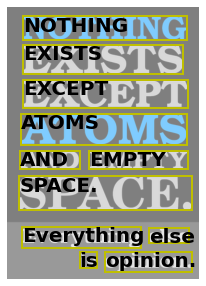

In [161]:
plt.figure(figsize=(5,5))

image  = Image.open(BytesIO(requests.get(image_url).content))
ax     = plt.imshow(image, alpha=0.5)
for word in word_infos:
    bbox = [int(num) for num in word["boundingBox"].split(",")]
    text = word["text"]
    origin = (bbox[0], bbox[1])
    patch  = Rectangle(origin, bbox[2], bbox[3], fill=False, linewidth=2, color='y')
    ax.axes.add_patch(patch)
    plt.text(origin[0], origin[1], text, fontsize=20, weight="bold", va="top")
_ = plt.axis("off")

## Text recognition with Computer Vision API <a name="RecognizeText"> </a>

Use the [Recognize Text method](https://westcentralus.dev.cognitive.microsoft.com/docs/services/5adf991815e1060e6355ad44/operations/587f2c6a154055056008f200) to asynchronously detect handwritten or printed text in an image and extract recognized characters into a machine-usable character stream.

Set `image_url` to point to the image to be recognized.

In [162]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/d/dd/Cursive_Writing_on_Notebook_paper.jpg/800px-Cursive_Writing_on_Notebook_paper.jpg"

The service endpoint for the text recognition service can be constructed as follows:

In [163]:
text_recognition_url = vision_base_url + "recognizeText"
print(text_recognition_url)

https://westeurope.api.cognitive.microsoft.com/vision/v2.0/recognizeText


The handwritten text recognition service can be used to recognize the text in the image. In the `params` dictionary, you can set `mode` to `Printed` to recognize only printed text.

In [164]:
headers  = {'Ocp-Apim-Subscription-Key': subscription_key}
params   = {'mode' : 'Handwritten'}
data     = {'url': image_url}
response = requests.post(text_recognition_url, headers=headers, params=params, json=data)
response.raise_for_status()

The text recognition service does not return the recognized text by itself. Instead, it returns immediately with an "Operation Location" URL in the response header that must be polled to get the result of the operation.

In [165]:
operation_url = response.headers["Operation-Location"]

After obtaining the `operation_url`, you can query it for the analyzed text. The following lines of code implement a polling loop in order to wait for the operation to complete. Notice that the polling is done via an HTTP `GET` method instead of `POST`.

In [166]:
import time

analysis = {}
while not "recognitionResult" in analysis:
    response_final = requests.get(response.headers["Operation-Location"], headers=headers)
    analysis       = response_final.json()
    time.sleep(1)

Next, the recognized text along with the bounding boxes can be extracted as shown in the following line of code. An important point to note is that the handwritten text recognition API returns bounding boxes as **polygons** instead of **rectangles**. Each polygon is _p_ is defined by its vertices specified using the following convention:

<i>p</i> = [<i>x</i><sub>1</sub>, <i>y</i><sub>1</sub>, <i>x</i><sub>2</sub>, <i>y</i><sub>2</sub>, ..., <i>x</i><sub>N</sub>, <i>y</i><sub>N</sub>]

In [167]:
polygons = [(line["boundingBox"], line["text"]) for line in analysis["recognitionResult"]["lines"]]

Finally, the recognized text can be overlaid on top of the original image using the extracted polygon information. Notice that `matplotlib` requires the vertices to be specified as a list of tuples of the form:

<i>p</i> = [(<i>x</i><sub>1</sub>, <i>y</i><sub>1</sub>), (<i>x</i><sub>2</sub>, <i>y</i><sub>2</sub>), ..., (<i>x</i><sub>N</sub>, <i>y</i><sub>N</sub>)]

and the post-processing code transforms the polygon data returned by the service into the form required by `matplotlib`.

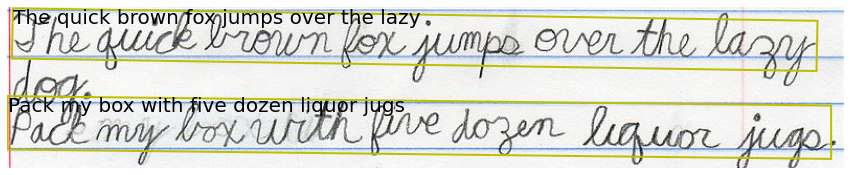

In [168]:
from matplotlib.patches import Polygon

plt.figure(figsize=(15,15))

image  = Image.open(BytesIO(requests.get(image_url).content))
ax     = plt.imshow(image)
for polygon in polygons:
    vertices = [(polygon[0][i], polygon[0][i+1]) for i in range(0,len(polygon[0]),2)]
    text     = polygon[1]
    patch    = Polygon(vertices, closed=True,fill=False, linewidth=2, color='y')
    ax.axes.add_patch(patch)
    plt.text(vertices[0][0], vertices[0][1], text, fontsize=20, va="top")
_ = plt.axis("off")